In [ ]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torch

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

test_transform = transforms.Compose(
    [ transforms.RandomHorizontalFlip(),
      transforms.RandomRotation(10),
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))])

trainset_raw = FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=train_transform)
test = FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=test_transform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 191kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.6MB/s]


In [ ]:
from sklearn.model_selection import train_test_split

train_indices, dev_indices = train_test_split(range(len(trainset_raw)), test_size=0.2, random_state=42, shuffle=True)
dev = torch.utils.data.Subset(trainset_raw, dev_indices)
train = torch.utils.data.Subset(trainset_raw, train_indices)

In [ ]:
batch_size = 32

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

devloader = torch.utils.data.DataLoader(dev, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
model = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 239MB/s]


In [ ]:
dataiter = iter(devloader)
images, labels = next(dataiter)

print(f"Shape of images in a batch: {images.shape}")
print(f"Shape of labels in a batch: {labels.shape}")

print(images[0])

Shape of images in a batch: torch.Size([32, 1, 224, 224])
Shape of labels in a batch: torch.Size([32])
tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


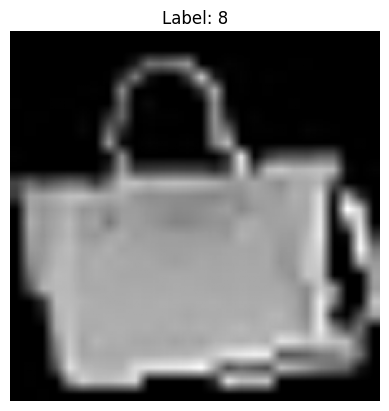

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

image = images[0]


image = image * 0.5 + 0.5
image = image.numpy().squeeze()

plt.imshow(image, cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()

In [ ]:
num_labels = len(train.dataset.classes)
print(f"FashionMNIST has {num_labels} labels.")
print(f"The labels are: {train.dataset.classes}")

FashionMNIST has 10 labels.
The labels are: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [ ]:
from torchsummary import summary
import torch.nn as nn

class GrayToRGB(nn.Module):
    def forward(self, x):
        return x.repeat(1, 3, 1, 1)


model_adapted = nn.Sequential(
    GrayToRGB(),
    model
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adapted.to(device)

summary(model_adapted, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GrayToRGB-1          [-1, 3, 224, 224]               0
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]          36,864
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
       BasicBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
import torch.nn as nn

num_ftrs = model_adapted[1].fc.in_features

model_adapted[1].fc = nn.Identity()


for param in model_adapted[1].parameters():
    param.requires_grad = False

print("ResNet50 classification head removed and all original ResNet layers frozen.")

ResNet50 classification head removed and all original ResNet layers frozen.


In [ ]:
hidden_size = 512

model_adapted[1].fc = nn.Sequential(
    nn.Linear(num_ftrs, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, num_labels)
)

model_adapted[1].fc.to(device)

for param in model_adapted[1].fc.parameters():
    param.requires_grad = True


summary(model_adapted, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         GrayToRGB-1            [-1, 3, 28, 28]               0
            Conv2d-2           [-1, 64, 14, 14]           9,408
       BatchNorm2d-3           [-1, 64, 14, 14]             128
              ReLU-4           [-1, 64, 14, 14]               0
         MaxPool2d-5             [-1, 64, 7, 7]               0
            Conv2d-6             [-1, 64, 7, 7]          36,864
       BatchNorm2d-7             [-1, 64, 7, 7]             128
              ReLU-8             [-1, 64, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          36,864
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
       BasicBlock-12             [-1, 64, 7, 7]               0
           Conv2d-13             [-1, 64, 7, 7]          36,864
      BatchNorm2d-14             [-1, 6

In [ ]:
import torch.optim as optim
import torch.nn.functional as F

def train_model(model, trainloader, devloader, optimizer, criterion, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    dev_losses = []

    print(f"Training on {device}")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        current_train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        print(f'Epoch {epoch + 1}, Training Loss: {current_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        # Validation phase
        model.eval()
        correct_dev = 0
        total_dev = 0
        dev_loss = 0.0
        with torch.no_grad():
            for data in devloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                dev_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_dev += labels.size(0)
                correct_dev += (predicted == labels).sum().item()

        current_dev_loss = dev_loss / len(devloader)
        dev_accuracy = 100 * correct_dev / total_dev
        print(f'              Development Loss: {current_dev_loss:.4f}, Development Accuracy: {dev_accuracy:.2f}%')

        train_losses.append(current_train_loss)
        dev_losses.append(current_dev_loss)

    print('Finished Training')
    return train_losses, dev_losses

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(model_adapted.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(f"Using Adam optimizer with learning rate: {learning_rate}")
print(f"Using CrossEntropyLoss as criterion")

Using Adam optimizer with learning rate: 0.001
Using CrossEntropyLoss as criterion


In [ ]:
epochs = 5
train_losses, dev_losses = train_model(model_adapted, trainloader, devloader, optimizer, criterion, epochs=epochs)

Training on cuda
Epoch 1, Training Loss: 0.6685, Training Accuracy: 75.79%
              Development Loss: 0.5121, Development Accuracy: 81.47%
Epoch 2, Training Loss: 0.5226, Training Accuracy: 81.25%
              Development Loss: 0.4411, Development Accuracy: 83.79%
Epoch 3, Training Loss: 0.4855, Training Accuracy: 82.59%
              Development Loss: 0.4240, Development Accuracy: 85.00%
Epoch 4, Training Loss: 0.4679, Training Accuracy: 83.18%
              Development Loss: 0.4192, Development Accuracy: 84.77%
Epoch 5, Training Loss: 0.4470, Training Accuracy: 83.73%
              Development Loss: 0.4119, Development Accuracy: 84.60%
Finished Training


In [ ]:
from sklearn.metrics import classification_report

model_adapted.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_adapted(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=train.dataset.classes))

              precision    recall  f1-score   support

 T-shirt/top       0.77      0.83      0.80      1000
     Trouser       0.92      0.97      0.95      1000
    Pullover       0.77      0.83      0.80      1000
       Dress       0.87      0.76      0.81      1000
        Coat       0.76      0.77      0.77      1000
      Sandal       0.97      0.89      0.93      1000
       Shirt       0.67      0.60      0.64      1000
     Sneaker       0.84      0.96      0.89      1000
         Bag       0.94      0.97      0.95      1000
  Ankle boot       0.97      0.88      0.92      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



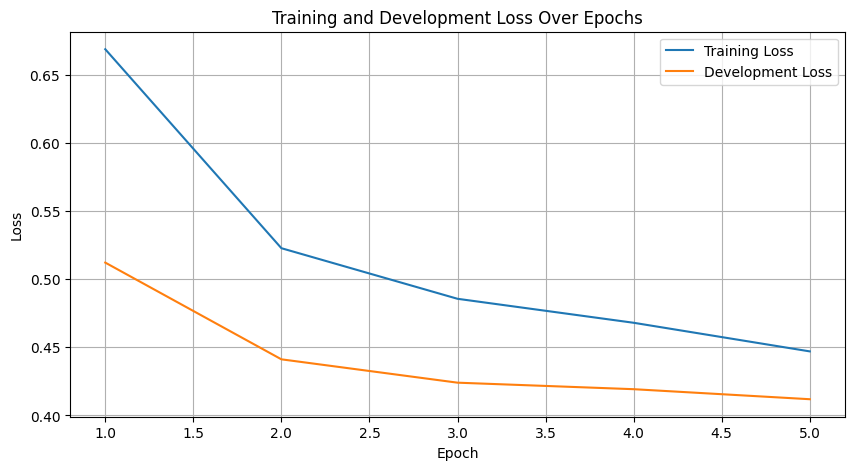

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), dev_losses, label='Development Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Development Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()